In [1]:
# This plot should just give me some idea of the ICON domain:

import xarray as xr
import numpy as np
import seaborn as sns
import netCDF4 as nc4
import math
import glob, os
from datetime import datetime

import psyplot.project as psy

import matplotlib as mpl
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import MaxNLocator
import matplotlib.tri as tri

# Cartopy is used independently from psyplot
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER,LATITUDE_FORMATTER
plt.rc('font', size=12) 
plt.style.use('seaborn-poster')

#####################################

outputdir = "/home/qwertz/Dokumente/N_eigene_Dokumente/Geo_Met_MSc/Semester_4_5/Thesis_prep_Juni_23/MA/master_plots/03_ICON_domain/"

sns.set()

case = "MESSy_ICON"

filein="bla"



/home/qwertz/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/qwertz/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Read grid on which to plot data:
from geopy.distance import geodesic

gridfilename = "/home/qwertz/data_js_icon_22_23_August_2018/chile_square_0628m.nc"

print("opening " + gridfilename)
f = nc4.Dataset(gridfilename,'r')


vlon           = np.array(f.variables["vlon"][:])               #(vertex)  double  vertex longitude radian

vlat           = np.array(f.variables["vlat"][:])               #(vertex)  double  vertex latitude  radian

vertex_of_cell = np.array(f.variables["vertex_of_cell"][:,:])   #(nv, cell)  int  vertices of each cell


nvert = vertex_of_cell.shape[0]
ncell = vertex_of_cell.shape[1]

print( (nvert,ncell))

f.close()

print("done")

print( (np.nanmin(np.rad2deg(vlon)),np.nanmax(np.rad2deg(vlon))))
print( (np.nanmin(np.rad2deg(vlat)),np.nanmax(np.rad2deg(vlat))))

reference_point = (np.nanmin(np.rad2deg(vlat)), np.nanmax(np.rad2deg(vlon)))
target_point = (np.nanmin(np.rad2deg(vlat)), np.nanmin(np.rad2deg(vlon)))
print(geodesic(reference_point,target_point).kilometers)
reference_point = (np.nanmin(np.rad2deg(vlat)), np.nanmin(np.rad2deg(vlon)))
target_point = (np.nanmax(np.rad2deg(vlat)), np.nanmin(np.rad2deg(vlon)))
print(geodesic(reference_point,target_point).kilometers)

opening /home/qwertz/data_js_icon_22_23_August_2018/chile_square_0628m.nc
(3, 252448)
done
(-71.26770589140338, -68.03268109436902)
(-22.050911791351567, -19.329505537207908)
333.92999051506865
301.2955506700564


In [3]:
# Opening data to plot on grid:
# <xarray.DataArray 'HBr_gas' (time: 1, lev: 90, ncells: 20480)>

filename = "/home/qwertz/data_js_icon_22_23_August_2018/cloud_DOM01.20180822.selvar.int.nc"

print("opening " + filename)
f = nc4.Dataset(filename,'r')

##########################
print(f.variables["tqc"])
###########################

qc_int = np.array(f.variables["tqc"][0,:])   #int64 qc(time, height, ncells) 
# nur ein Zeitschritt + Summierung entlang der Höhenlevel!!!

f.close()

print("done")

print(np.shape(qc_int))

opening /home/qwertz/data_js_icon_22_23_August_2018/cloud_DOM01.20180822.selvar.int.nc
<class 'netCDF4._netCDF4.Variable'>
float32 tqc(time, ncells)
    standard_name: tqc
    long_name: total column integrated cloud water
    units: kg m-2
    param: 69.1.0
    CDI_grid_type: unstructured
    number_of_grid_in_reference: 1
    coordinates: clat clon
unlimited dimensions: time
current shape = (133, 252448)
filling on, default _FillValue of 9.969209968386869e+36 used
done
(252448,)


In [4]:
# Add ICON global data for wind vectors:

import numpy as np
import xarray as xr
from scipy.interpolate import griddata

path_icon = "/home/qwertz/forcing_icon/icon20180822/"
gridfile = "icon_grid_chile_R03B07_20180103.nc"
extpar_file = "icon_extpar_chile_R03B07_20180103.nc"
file = "entpackt/2018/08/2018082200_icon.nc"

gridds = xr.open_dataset(path_icon+gridfile)
datads = xr.open_dataset(path_icon+file)
extpards = xr.open_dataset(path_icon+extpar_file )

##############
#u_vec = datads["u"].isel(height_2=69).isel(time=5).values
#v_vec = datads["v"].isel(height_2=69).isel(time=5).values
#x_vec = np.rad2deg(extpards["clon"].values)
#y_vec = np.rad2deg(extpards["clat"].values)
###########

########################################
# regrid on lat longitude:

x_vec = np.linspace(np.nanmin(np.rad2deg(extpards["clon"].values)),np.nanmax(np.rad2deg(extpards["clon"].values)),8)
y_vec = np.linspace(np.nanmin( np.rad2deg(extpards["clat"].values)),np.nanmax( np.rad2deg(extpards["clat"].values)),15)
lon_grid, lat_grid = np.meshgrid(x_vec, y_vec) # lon_grid_ravel ist zu kurz...

original_us = datads["u"].isel(height_2=69).isel(time=5).values
original_vs = datads["v"].isel(height_2=69).isel(time=5).values
original_lons = np.rad2deg(extpards["clon"].values)
original_lats = np.rad2deg(extpards["clat"].values)

u_vec = griddata((original_lons, original_lats),\
                               original_us, (lon_grid.ravel(), lat_grid.ravel()))
# u_vec = np.reshape(interpolated_values, (len(height_vector), len(lon_vector)))
v_vec = griddata((original_lons, original_lats),\
                               original_vs, (lon_grid.ravel(), lat_grid.ravel()))


# [x_vec, y_vec], u_vec, v_vec
# -70.7772694, -21.039444



/tmp/ipykernel_13413/616199144.py:56: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  ax.plot(-70.1772694, -21.539444, 'bo', markersize=7, transform=ccrs.Geodetic(), color="red")
/tmp/ipykernel_13413/616199144.py:60: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  ax.plot(-70.375, -23.625, 'bo', markersize=7, transform=ccrs.Geodetic(), color="red")
/tmp/ipykernel_13413/616199144.py:62: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  ax.plot(-70.65, -33.4375, 'bo', markersize=7, transform=ccrs.Geodetic(), color="red")
/tmp/ipykernel_13413/616199144.py:66: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> colo

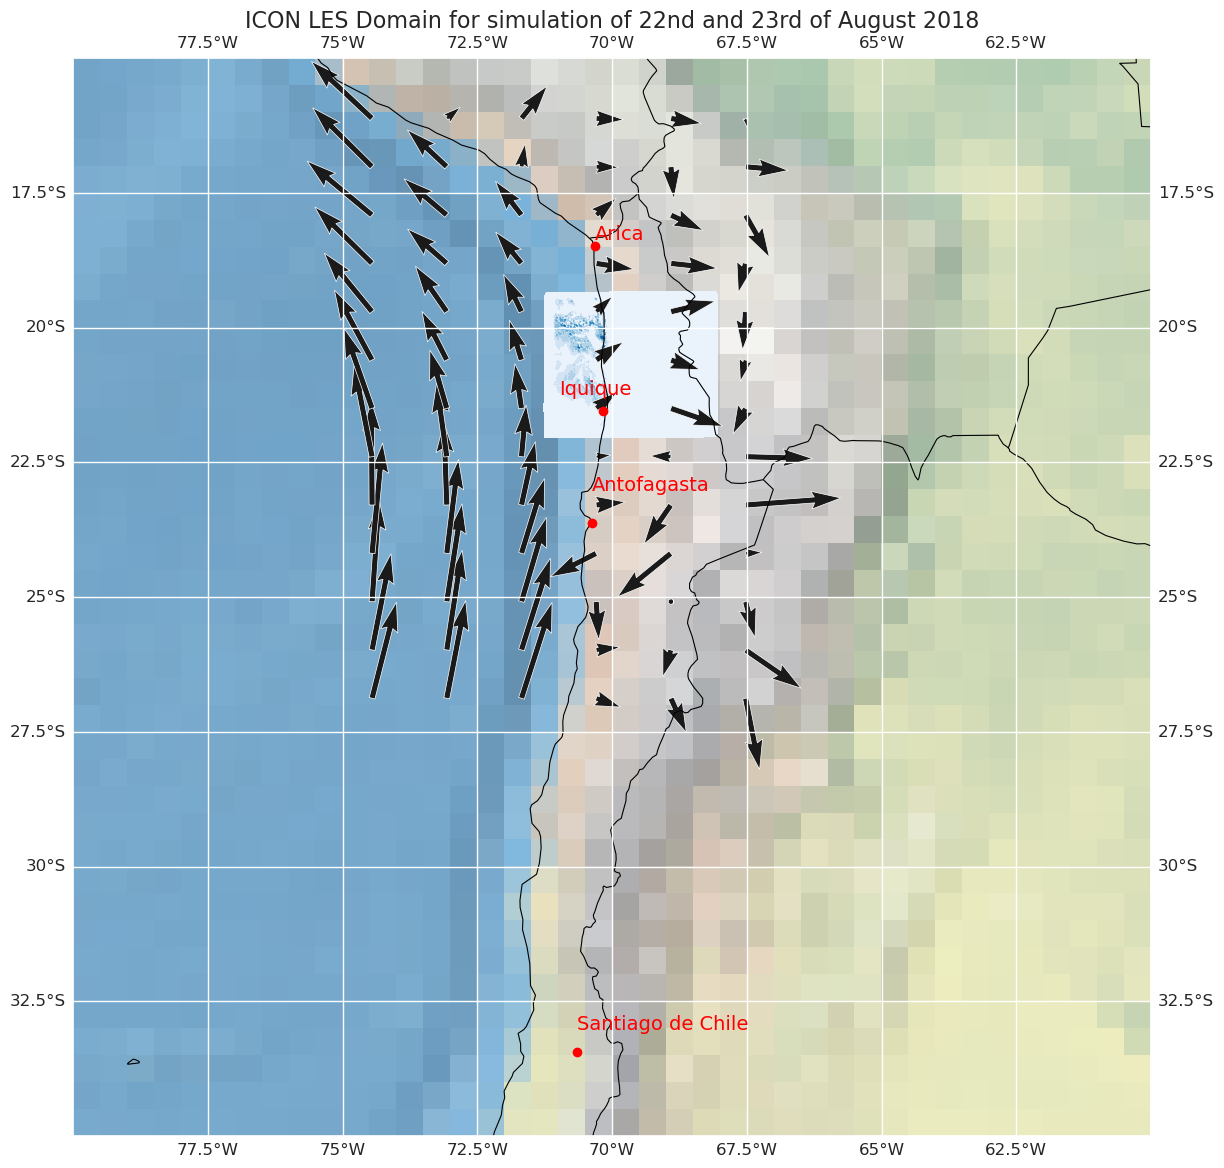

In [7]:


# Convert vertex coordinates from radians to degrees
x      = np.rad2deg(vlon)
y      = np.rad2deg(vlat)


# Create  Delaunay triangulation. 
triang = tri.Triangulation(x, y)
triang = tri.Triangulation(x, y)


# Use matplotlib's triplot to visualize the grid *without knowing which vertices belong to which cell*
# fig, ax = plt.subplots(figsize=(24,12))

fig = plt.figure(figsize=(14,14))
pc = ccrs.PlateCarree()
ax = plt.axes(projection=pc)
ax.stock_img()
ax.coastlines('50m', linewidth=0.8)
#ax.add_feature(cfeature.LAKES,
#               edgecolor='blue', facecolor='none',
#               linewidth=0.8)

############################
# ax.add_feature(cfeature.STAMEN_TERRAIN)
# ax.add_feature(cfeature.STAMEN_TERRAIN_BACKGROUND)
#ax.add_feature(cfeature.STAMEN_WATERCOLOR)
# ax.add_feature(cfeature.STAMEN_TONER)
ax.add_feature(cfeature.OCEAN)
# ax.add_feature(cfeature.GSHHS)
#############################

ax.add_feature(cfeature.BORDERS,
               edgecolor='black', facecolor='none',
               linewidth=0.8)
ax.set_extent([-80, -60, -35, -15], crs=ccrs.PlateCarree())
ax.gridlines(draw_labels=True)

ax.set_aspect('equal')
###########################################################
# ax.triplot(triang, 'bo-', lw=1, color="red", alpha=0.1)
triangles = np.transpose(vertex_of_cell) - 1   
xmid = x[triangles].mean(axis = 1) 
ymid = y[triangles].mean(axis = 1) 
tpc = ax.tricontourf(xmid, ymid, qc_int, cmap="Blues")
##############################################################
ax.set_title('ICON LES Domain for simulation of 22nd and 23rd of August 2018', fontsize=16)
ax.set_xlabel('Longitude (degrees)')
ax.set_ylabel('Latitude (degrees)')
ax.quiver(lon_grid.ravel(), lat_grid.ravel(), u_vec, v_vec,linewidth=0.5)# , width=1.5) #,scale=1.5)

#########################
# Adding Cities:

size = 14
ax.text(-70.9772694, -21.239444, 'Iquique', transform=ccrs.Geodetic(), color="red", fontsize=size)
ax.plot(-70.1772694, -21.539444, 'bo', markersize=7, transform=ccrs.Geodetic(), color="red")
# IQQ: -20.539444 ; -70.1772694 (-20.125 == index 279; -70.125 == index 1159)
# Anto: -23.65, -70.4 (-23.625 index==265; -70.375 289.625== index 1158)
ax.text(-70.375, -23.025, 'Antofagasta', transform=ccrs.Geodetic(), color="red", fontsize=size)
ax.plot(-70.375, -23.625, 'bo', markersize=7, transform=ccrs.Geodetic(), color="red")
ax.text(-70.65, -33.0375, 'Santiago de Chile', transform=ccrs.Geodetic(), color="red", fontsize=size)
ax.plot(-70.65, -33.4375, 'bo', markersize=7, transform=ccrs.Geodetic(), color="red")
#ax.text(-77.0375, -11.56, 'Lima', transform=ccrs.Geodetic(), fontsize=12)
#ax.plot(-77.0375, -12.06, 'bo', markersize=7, transform=ccrs.Geodetic(), color="black")
ax.text(-70.318056, -18.377778, 'Arica', transform=ccrs.Geodetic(), color="red", fontsize=size)
ax.plot(-70.318056, -18.477778, 'bo', markersize=7, transform=ccrs.Geodetic(), color="red")

plt.show()

fig.savefig(outputdir+'ICON_LES_domain.png', bbox_inches='tight')

plt.close(fig)


In [6]:
# Calculate resolution:

gridfile = "icon_grid_chile_R03B07_20180103.nc"
path_icon = "/home/qwertz/forcing_icon/icon20180822/"
gridds = xr.open_dataset(path_icon+gridfile)

print(gridds.data_vars)

# print(gridds["edge_length"])
print(gridds["edge_of_cell"].values)

Data variables:
    longitude_vertices             (vertex) float64 37kB ...
    latitude_vertices              (vertex) float64 37kB ...
    clon_vertices                  (cell, nv) float64 216kB ...
    clat_vertices                  (cell, nv) float64 216kB ...
    vlon_vertices                  (vertex, ne) float64 224kB ...
    vlat_vertices                  (vertex, ne) float64 224kB ...
    cell_area                      (cell) float64 72kB ...
    lon_edge_centre                (edge) float64 109kB ...
    lat_edge_centre                (edge) float64 109kB ...
    edge_of_cell                   (nv, cell) int32 108kB ...
    vertex_of_cell                 (nv, cell) int32 108kB ...
    adjacent_cell_of_edge          (nc, edge) int32 109kB ...
    edge_vertices                  (nc, edge) int32 109kB ...
    cells_of_vertex                (ne, vertex) int32 112kB ...
    edge_length                    (edge) float64 109kB ...
    zonal_normal_primal_edge       (edge) float64 1